## How to read BigQuery data from TensorFlow 2.0 efficiently

This notebook accompanies the article 
["How to read BigQuery data from TensorFlow 2.0 efficiently"](https://medium.com/@lakshmanok/how-to-read-bigquery-data-from-tensorflow-2-0-efficiently-9234b69165c8)

The example problem is to find credit card fraud from the dataset published in:
<i>
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
</i>
and available in BigQuery at <pre>bigquery-public-data.ml_datasets.ulb_fraud_detection</pre>

## Benchmark Model

In order to compare things, we will do a simple logistic regression in BigQuery ML.

Note that we are using all the columns in the dataset as predictors (except for the Time and Class columns).
The Time column is used to split the dataset 80:20 with the first 80% used for training and the last 20% used for evaluation.
We will also have BigQuery ML automatically balance the weights.

Because the Amount column has a huge range, we take the log of it in preprocessing.

In [ ]:
%%bash
# create output dataset
bq mk advdata

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL advdata.ulb_fraud_detection 
TRANSFORM(
    * EXCEPT(Amount),
    SAFE.LOG(Amount) AS log_amount
)
OPTIONS(
    INPUT_LABEL_COLS=['class'],
    AUTO_CLASS_WEIGHTS = TRUE,
    DATA_SPLIT_METHOD='seq',
    DATA_SPLIT_COL='Time',
    MODEL_TYPE='logistic_reg'
) AS

SELECT 
 *
FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`

In [10]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL advdata.ulb_fraud_detection)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.051938,0.893333,0.978374,0.098168,0.119626,0.98633


In [15]:
%%bigquery
SELECT predicted_class_probs, Class
FROM ML.PREDICT( MODEL advdata.ulb_fraud_detection,
  (SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection` WHERE Time = 85285.0)
)

,predicted_class_probs,Class
0,"[{'label': 1, 'prob': 0.08119100590923363}, {'...",0
1,"[{'label': 1, 'prob': 0.999999999367996}, {'la...",1
2,"[{'label': 1, 'prob': 0.999999999367996}, {'la...",1
3,"[{'label': 1, 'prob': 0.9999999994848612}, {'l...",1
4,"[{'label': 1, 'prob': 0.9999999994848612}, {'l...",1


## Find the breakoff point etc. for Keras

When we do the training in Keras & TensorFlow, we need to find the place to split the dataset and how to weight the imbalanced data.
(BigQuery ML did that for us because we specified 'seq' as the split method and auto_class_weights to be True).

In [11]:
%%bigquery
WITH counts AS (
SELECT
    APPROX_QUANTILES(Time, 5)[OFFSET(4)] AS train_cutoff
    , COUNTIF(CLASS > 0) AS pos
    , COUNTIF(CLASS = 0) AS neg
FROM `bigquery-public-data`.ml_datasets.ulb_fraud_detection
)

SELECT
   train_cutoff
    , SAFE.LOG(SAFE_DIVIDE(pos,neg)) AS output_bias
    , 0.5*SAFE_DIVIDE(pos + neg, pos) AS weight_pos
    , 0.5*SAFE_DIVIDE(pos + neg, neg) AS weight_neg
FROM counts

,train_cutoff,output_bias,weight_pos,weight_neg
0,144803.0,-6.359359,289.438008,0.500865


The time cutoff is 144803 and the Keras model's output bias needs to be set at -6.36
The class weights need to be 289.4 and 0.5

## Training a TensorFlow/Keras model that reads from BigQuery

Create the dataset from BigQuery

In [1]:
import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession

def features_and_labels(features):
  label = features.pop('Class') # this is what we will train for
  return features, label

def read_dataset(client, row_restriction, batch_size=2048):
    GCP_PROJECT_ID='ai-analytics-solutions'  # CHANGE
    COL_NAMES = ['Time', 'Amount', 'Class'] + ['V{}'.format(i) for i in range(1,29)]
    COL_TYPES = [dtypes.float64, dtypes.float64, dtypes.int64] + [dtypes.float64 for i in range(1,29)]
    DATASET_GCP_PROJECT_ID, DATASET_ID, TABLE_ID,  = 'bigquery-public-data.ml_datasets.ulb_fraud_detection'.split('.')
    bqsession = client.read_session(
        "projects/" + GCP_PROJECT_ID,
        DATASET_GCP_PROJECT_ID, TABLE_ID, DATASET_ID,
        COL_NAMES, COL_TYPES,
        requested_streams=2,
        row_restriction=row_restriction)
    dataset = bqsession.parallel_read_rows()
    return dataset.prefetch(1).map(features_and_labels).shuffle(batch_size*10).batch(batch_size)

client = BigQueryClient()

In [2]:
temp_df = read_dataset(client, 'Time <= 144803', 2)
for row in temp_df:
    print(row)
    break

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
(OrderedDict([('Amount', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0., 0.])>), ('Time', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([820., 912.])>), ('V1', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.93748131,  1.08300282])>), ('V10', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.66669886,  0.45323987])>), ('V11', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.34374585, -0.75502041])>), ('V12', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42906363,  0.18404053])>), ('V13', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1.32585737, -0.10756875])>), ('V14', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.10021293, -0.36109129])>), ('V15', <tf.Tensor: shape=(2,), dtype=float64, numpy=arr

In [3]:
train_df = read_dataset(client, 'Time <= 144803', 2048)
eval_df = read_dataset(client, 'Time > 144803', 2048)

Create Keras model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



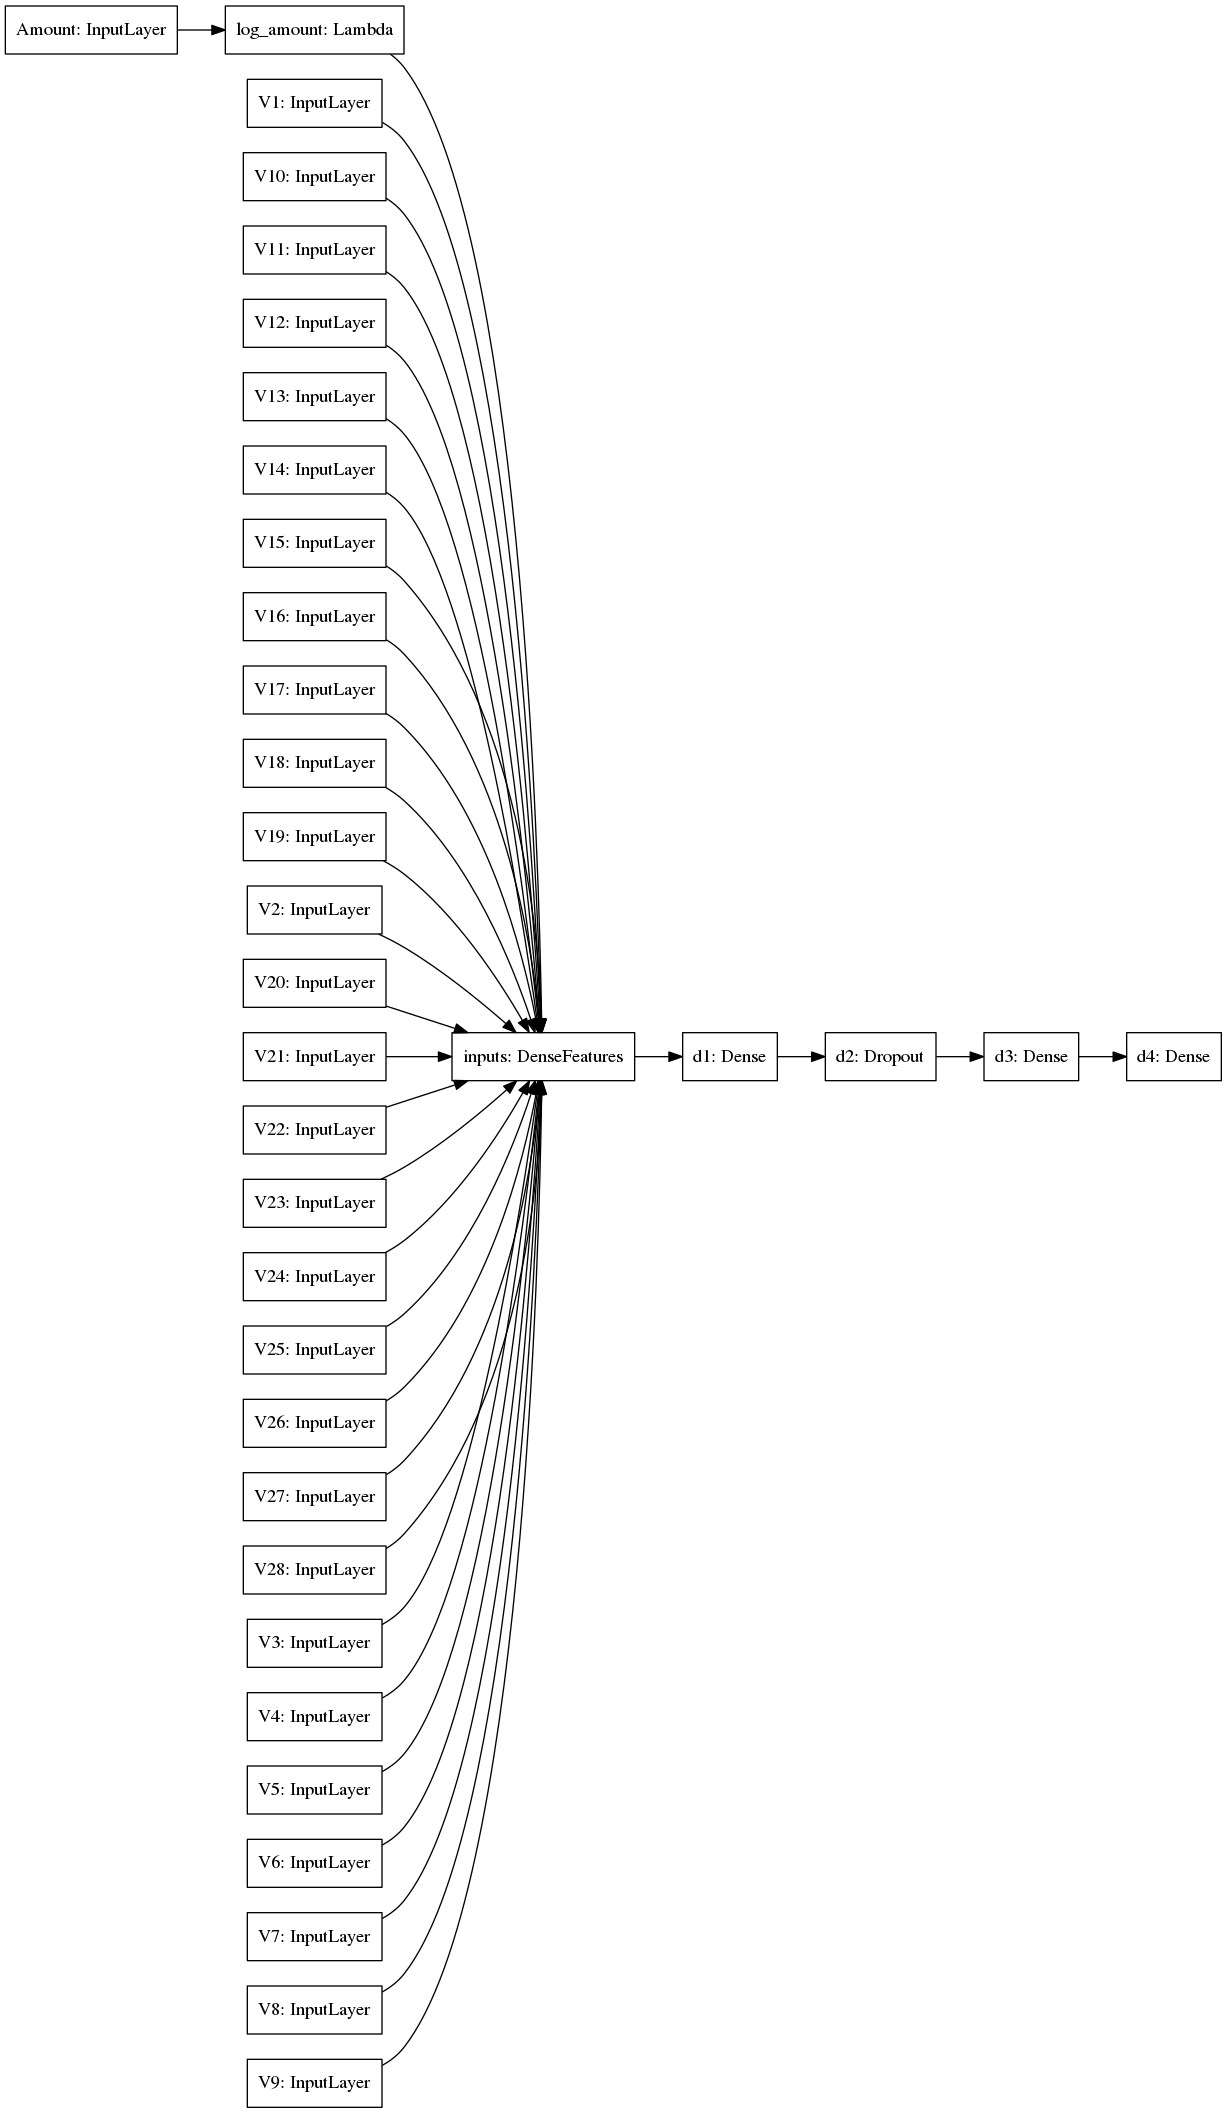

In [7]:
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc_auc'),
]

# create inputs, and pass them into appropriate types of feature columns (here, everything is numeric)
inputs = {
    'V{}'.format(i) : tf.keras.layers.Input(name='V{}'.format(i), shape=(), dtype='float64') for i in range(1, 29)
}
inputs['Amount'] = tf.keras.layers.Input(name='Amount', shape=(), dtype='float64')
input_fc = [tf.feature_column.numeric_column(colname) for colname in inputs.keys()]

# transformations. only the Amount is transformed
transformed = inputs.copy()
transformed['Amount'] = tf.keras.layers.Lambda(
    lambda x: tf.math.log(tf.math.maximum(x, 0.01)), name='log_amount')(inputs['Amount'])
input_layer = tf.keras.layers.DenseFeatures(input_fc, name='inputs')(transformed)

# Deep learning model
d1 = tf.keras.layers.Dense(16, activation='relu', name='d1')(input_layer)
d2 = tf.keras.layers.Dropout(0.25, name='d2')(d1)
d3 = tf.keras.layers.Dense(16, activation='relu', name='d3')(d2)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='d4', bias_initializer=tf.keras.initializers.Constant())(d3)

model = tf.keras.Model(inputs, output)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)
tf.keras.utils.plot_model(model, rankdir='LR')

In [9]:
class_weight = {0: 0.5, 1: 289.4}
history = model.fit(train_df, validation_data=eval_df, epochs=20, class_weight=class_weight)

Epoch 1/20
111/111 [==============================] - 97s 873ms/step - loss: 1.1395 - accuracy: 0.9988 - precision: 0.7643 - recall: 0.4843 - roc_auc: 0.8522 - val_loss: 0.3859 - val_accuracy: 0.9994 - val_precision: 0.8209 - val_recall: 0.7143 - val_roc_auc: 0.9052
Epoch 2/20
111/111 [==============================] - 98s 883ms/step - loss: 0.2866 - accuracy: 0.9861 - precision: 0.1001 - recall: 0.8289 - roc_auc: 0.9408 - val_loss: 0.2099 - val_accuracy: 0.9886 - val_precision: 0.0918 - val_recall: 0.8571 - val_roc_auc: 0.9430
Epoch 3/20
111/111 [==============================] - 83s 750ms/step - loss: 0.2523 - accuracy: 0.9755 - precision: 0.0610 - recall: 0.8602 - roc_auc: 0.9502 - val_loss: 0.2207 - val_accuracy: 0.9842 - val_precision: 0.0678 - val_recall: 0.8571 - val_roc_auc: 0.9505
Epoch 4/20
111/111 [==============================] - 87s 782ms/step - loss: 0.2524 - accuracy: 0.9708 - precision: 0.0514 - recall: 0.8554 - roc_auc: 0.9503 - val_loss: 0.1968 - val_accuracy: 0.9797

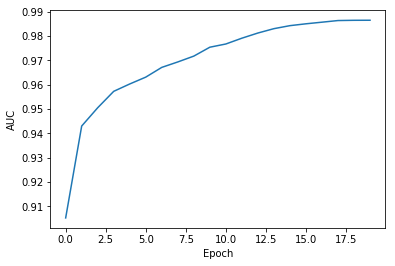

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_roc_auc']);
plt.xlabel('Epoch');
plt.ylabel('AUC');

## Load TensorFlow model into BigQuery

Now that we have trained a TensorFlow model off BigQuery data ...
let's load the model into BigQuery and use it for batch prediction!

In [14]:
BUCKET='ai-analytics-solutions-kfpdemo'  # CHANGE TO SOMETHING THAT YOU OWN
model.save('gs://{}/bqexample/export'.format(BUCKET))

INFO:tensorflow:Assets written to: gs://ai-analytics-solutions-kfpdemo/bqexample/export/assets


In [ ]:
%%bigquery
CREATE OR REPLACE MODEL advdata.keras_fraud_detection 
OPTIONS(model_type='tensorflow', model_path='gs://ai-analytics-solutions-kfpdemo/bqexample/export/*')

Now predict with this model (the reason it's called 'd4' is because the output node of my Keras model was called 'd4').
To get probabilities, etc. we'd have to add the corresponding outputs to the Keras model.

In [19]:
%%bigquery
SELECT d4, Class
FROM ML.PREDICT( MODEL advdata.keras_fraud_detection,
  (SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection` WHERE Time = 85285.0)
)

,d4,Class
0,0.075196,0
1,1.000000,1
2,1.000000,1
3,1.000000,1
4,1.000000,1


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.